In [1]:
import sys
sys.path.append("../../")

import logging
logging.getLogger('tensorflow').disabled = True

# visualization
import numpy as np
import sklearn.datasets as skd
import matplotlib.pyplot as plt
from scipy.stats import kde
#progress bar
import tqdm
#smoothing loss history
from scipy.ndimage.filters import gaussian_filter1d
# tf and friends
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp
# FFJORD transport_nets keras model
from transport_nets.models import FFJORD
from transport_nets.mcmc import MetropolisHastings
from transport_nets.mcmc import model_log_prob

tf.enable_v2_behavior()

tfb = tfp.bijectors
tfd = tfp.distributions

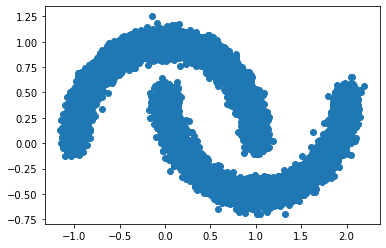

In [2]:
DATASET_SIZE = 20000 
BATCH_SIZE = 1000 

moons = skd.make_moons(n_samples=DATASET_SIZE, noise=.06)[0]

moons_ds = tf.data.Dataset.from_tensor_slices(moons.astype(np.float32))
moons_ds = moons_ds.prefetch(tf.data.experimental.AUTOTUNE)
moons_ds = moons_ds.cache()
moons_ds = moons_ds.shuffle(DATASET_SIZE)
moons_ds = moons_ds.batch(BATCH_SIZE)

plt.scatter(moons[:, 0], moons[:, 1])
plt.show()

In [3]:
OUTPUT_DIM = 2
NUM_BIJECTORS = 2
NEURON_LIST = [100,100]

LR = 1e-2
NUM_EPOCHS = 40
opt = tf.keras.optimizers.Adam(LR, epsilon=1e-08)

ffjord = FFJORD(OUTPUT_DIM,NUM_BIJECTORS,NEURON_LIST)
ffjord.compile(opt)
loss_history = ffjord.fit_custom(moons_ds,NUM_EPOCHS)
ffjord.training_mode(False)

loss: 0.640 : 100%|██████████| 40/40 [06:55<00:00, 10.39s/it]


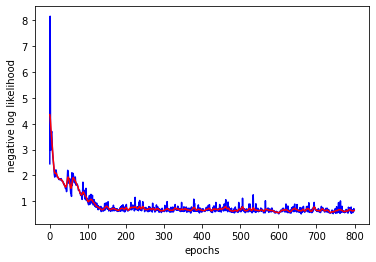

In [4]:
ysmoothed = gaussian_filter1d(loss_history, sigma=4)
plt.plot(loss_history,'b')
plt.plot(ysmoothed, color = 'r')
plt.xlabel('iterations')
plt.ylabel('negative log likelihood');

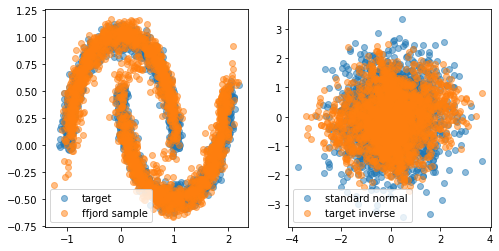

In [5]:
T = tf.constant(moons[::10],dtype=tf.float32)
N_samps = T.shape[0]
X = ffjord.sample(N_samps)

fig,ax = plt.subplots(1,2,figsize=(8,4))
ax[0].scatter(T[:,0],T[:,1],alpha=0.5,label='target')
ax[0].scatter(X[:,0],X[:,1],alpha=0.5,label='ffjord sample')
ax[0].legend()

R = ffjord.inverse(T)
Normal = tf.random.normal([R.shape[0],OUTPUT_DIM])
ax[1].scatter(Normal[:,0],Normal[:,1],alpha=0.5,label='standard normal')
ax[1].scatter(R[:,0],R[:,1],alpha=0.5,label='target inverse')
ax[1].legend();

In [9]:
# Run the algorithm
x2_star=[0.25]
init_val = [0.0]
b = 1.0
niters = 1000
log_prob_fn = model_log_prob(ffjord,y_given=x2_star)
samples,acc_rate,time = MetropolisHastings(init_val,b,niters,log_prob_fn)
print('acceptance rate: %0.3f'%acc_rate,'time: %0.3f'%time)

100%|██████████| 1000/1000 [02:50<00:00,  5.86it/s]


acceptance rate: 0.200 time: 170.694


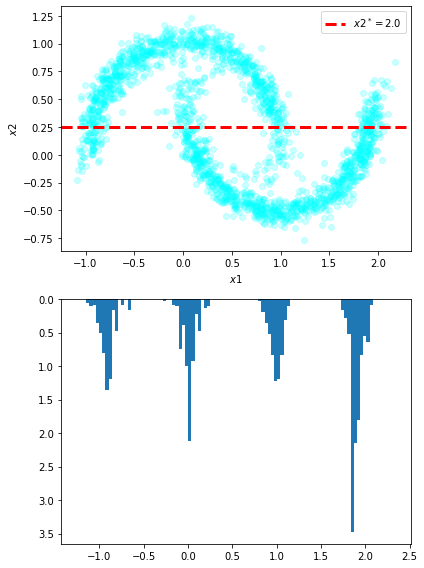

In [10]:
# plotting conditional sample
fig, ax = plt.subplots(2,1,figsize=(6,8))
forward_pass = ffjord.sample(2000)
ax[0].scatter(forward_pass[:, 0], forward_pass[:, 1], color='cyan',alpha=.2)
ax[0].axhline(y=x2_star, color='red', linestyle='--',lw=3.0,label='$x2^* = 2.0$')
ax[0].set(xlabel='$x1$',ylabel='$x2$')
ax[0].legend();
l,r = ax[0].get_xlim()
ax[1].hist(samples[:,0],100,(l,r),density=True)
ax[1].invert_yaxis()
plt.tight_layout()